<a href="https://colab.research.google.com/github/ssingh1187/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/DS41SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [43]:
!pip install category_encoders

     |████████████████████████████████| 92kB 5.3MB/s 


In [0]:
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance


In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [50]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._


In [51]:
print(train.shape)
print(test.shape)

(51916, 17)
(17306, 17)


In [52]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [53]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [54]:
train['Risk'].value_counts()

Risk 1 (High)      37731
Risk 2 (Medium)    10136
Risk 3 (Low)        4037
Name: Risk, dtype: int64

In [56]:
def wrangle(X):
  X = X.copy()
  
  # Dropping unwanted columns
  X = X.drop(columns = ['DBA Name',
               'AKA Name',
               'License #',
               'Address',
               'City',
               'State',
               'Zip',
               'Latitude',
               'Longitude'])

  X['Risk'] = X['Risk'].replace({'Risk 1 (High)': 1,
                              'Risk 2 (Medium)': 2,
                              'Risk 3 (Low)': 3})

# Number of days since last inspection
  X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True)
  X['Inspection Date'] = pd.Timestamp.today() - X['Inspection Date']
  X['Inspection Date'] = X['Inspection Date'].dt.days

# Replacing NaN values
  X['Facility Type'] = X['Facility Type'].fillna('Unknown')
  X['Risk'] = X['Risk'].fillna(0)
  X['Inspection Type'] = X['Inspection Type'].fillna('Unknown')
  X['Violations'] = X['Violations'].fillna('Unknown')
  X['Location'] = X['Location'].fillna('Unknown')


  return X

df_train = wrangle(train)
df_test = wrangle(test)

df_train.shape, df_test.shape

((51916, 8), (17306, 8))

In [57]:
df_train.head()

,Inspection ID,Facility Type,Risk,Inspection Date,Inspection Type,Violations,Location,Fail
0,2088270,Restaurant,1.0,608,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,Grocery Store,3.0,2765,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,Restaurant,1.0,1136,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...","{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,Restaurant,2.0,1112,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,School,1.0,3048,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",Unknown,0


In [58]:
df_train.isna().sum()

Inspection ID      0
Facility Type      0
Risk               0
Inspection Date    0
Inspection Type    0
Violations         0
Location           0
Fail               0
dtype: int64

In [59]:
df_train.dtypes

Inspection ID        int64
Facility Type       object
Risk               float64
Inspection Date      int64
Inspection Type     object
Violations          object
Location            object
Fail                 int64
dtype: object

In [60]:
X_train = df_train.drop(columns = ['Fail'])
y_train = df_train['Fail']

X_test = df_test.drop(columns = ['Fail'])
y_test = df_test['Fail']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((51916, 7), (51916,), (17306, 7), (17306,))

In [0]:
encoder = ce.OrdinalEncoder()
X = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

In [62]:
X.dtypes

Inspection ID        int64
Facility Type        int64
Risk               float64
Inspection Date      int64
Inspection Type      int64
Violations           int64
Location             int64
dtype: object

In [63]:
X.head()

,Inspection ID,Facility Type,Risk,Inspection Date,Inspection Type,Violations,Location
0,2088270,1,1.0,608,1,1,1
1,555268,2,3.0,2765,2,2,2
2,1751394,1,1.0,1136,3,3,3
3,1763905,1,2.0,1112,1,4,4
4,453326,3,1.0,3048,1,5,5


### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


In [66]:
pipe1 = make_pipeline(ce.OrdinalEncoder(),
                    DecisionTreeClassifier(max_depth=5, class_weight = 'balanced')
                     )

cross_val_score(pipe1, X_train, y_train, cv=5, scoring='roc_auc')

array([0.54919326, 0.56337427, 0.57568565, 0.58142803, 0.56337108])

In [67]:
pipe2 = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.005, 
        oob_score=True, 
        n_jobs=-1)
)

cross_val_score(pipe2, X_train, y_train, cv=5, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.6308881130123054, total=   6.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ....................... , score=0.6346099714888822, total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s


[CV] ....................... , score=0.6373141007870191, total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.5s remaining:    0.0s


[CV] ........................ , score=0.644262482262195, total=   4.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.1s remaining:    0.0s


[CV] ....................... , score=0.6409287909070194, total=   4.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.5s finished


array([0.63088811, 0.63460997, 0.6373141 , 0.64426248, 0.64092879])

In [88]:
rf_model =    RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.005, 
        oob_score=True, 
        n_jobs=-1)

rf_model.fit(X,y_train)

y_pred_proba = rf_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_proba)

0.6446494936973958

In [70]:
gb = GradientBoostingClassifier()
cross_val_score(gb, X, y_train, scoring='accuracy', cv=5, n_jobs=-1)

array([0.70868644, 0.76105172, 0.76615622, 0.76586728, 0.74333044])

In [75]:
gb.fit(X, y_train)
y_pred_proba = gb.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred_proba)

0.6421941448543136

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [80]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 1.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


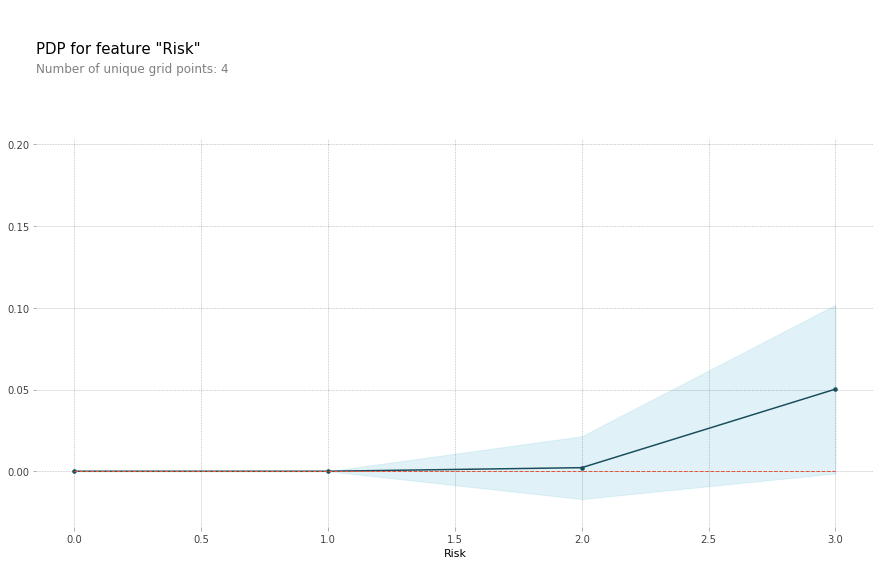

In [89]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Risk'

pdp_isolated = pdp_isolate(model=rf_model, dataset=X, 
                           model_features=X.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

In [86]:
!pip install eli5

     |████████████████████████████████| 102kB 4.3MB/s 


In [92]:
gb.fit(X, y_train)
permuter = PermutationImportance(gb, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X, y_train)

PermutationImportance(cv='prefit',
           estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
           n_iter=1, random_state=None, refit=True, scoring='roc_auc')

In [93]:
eli5.show_weights(permuter, top=None, feature_names=X.columns.tolist())

Weight,Feature
0.1436 ± 0.0000,Inspection Type
0.0779 ± 0.0000,Violations
0.0346 ± 0.0000,Inspection ID
0.0216 ± 0.0000,Inspection Date
0.0081 ± 0.0000,Facility Type
0.0055 ± 0.0000,Location
0.0055 ± 0.0000,Risk
